# ACM Digital Library bibliometric analysis of legacy software

![](http://dl.acm.org/images/ACMDL_Logo.jpg)

An incomplete bibliographical inquiry into what the [ACM Digital Library](http://dl.acm.org) has to say about legacy.

In [739]:
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import re
import numpy as np
import sklearn
%matplotlib inline

## Data loading, sanitization and massage

[Search "legacy" at ACM Digital Library](http://dl.acm.org/results.cfm?query=legacy&filtered=acmPubGroups%2EacmPubGroup=Proceeding&within=owners%2Eowner%3DHOSTED&dte=&bfr=&srt=%5Fscore). Just a simple search, to which the web interface gives 1541 results in mid November 2016. The number of items in the library is ~460000.

A CSV is downloaded from ACM DL, in default sorting order of the library's own idea of relevance... whatever that means for them. BibTeX is also available.

In [475]:
legacybib = pd.read_csv("ACMDL201612108240806.csv")

The available data columns are

In [476]:
legacybib.columns

Index(['type', 'id', 'author', 'editor', 'advisor', 'note', 'title', 'pages',
       'article_no', 'num_pages', 'keywords', 'doi', 'journal', 'issue_date',
       'volume', 'issue_no', 'description', 'month', 'year', 'issn',
       'booktitle', 'acronym', 'edition', 'isbn', 'conf_loc', 'publisher',
       'publisher_loc'],
      dtype='object')

A peek at the topmost data items.

In [477]:
legacybib.head(3)

,type,id,author,editor,advisor,note,title,pages,article_no,num_pages,...,month,year,issn,booktitle,acronym,edition,isbn,conf_loc,publisher,publisher_loc
0,article,505877,Sakib Abdul Mondal and Kingshuk Das Gupta,NaN,NaN,NaN,Choosing a Middleware for Web-integration of a...,50--53,NaN,4,...,May,2000,0163-5948,NaN,NaN,NaN,NaN,NaN,ACM,"New York, NY, USA"
1,article,2487308,Brandon Kyle Phillips and Sherry Ryan and Gin...,NaN,NaN,NaN,Motivating Students to Acquire Mainframe Skills,73--78,NaN,6,...,NaN,2013,NaN,Proceedings of the 2013 Annual Conference on C...,SIGMIS-CPR '13,NaN,978-1-4503-1975-1,"Cincinnati, Ohio, USA",ACM,"New York, NY, USA"
2,article,2048229,Dennis Mancl and Steven D. Fraser and Bill O...,NaN,NaN,NaN,Workshop: Beyond Green-field Software Developm...,321--322,NaN,2,...,NaN,2011,NaN,Proceedings of the ACM International Conferenc...,OOPSLA '11,NaN,978-1-4503-0942-4,"Portland, Oregon, USA",ACM,"New York, NY, USA"


Use the `id` field provided by ACM to identify the items. Hopefully the librarians have done a good job and the ids are unique and persistent.

In [479]:
legacybib.index = legacybib.id

What datatypes did Pandas infer from the CSV

In [480]:
legacybib.dtypes

type              object
id                object
author            object
editor            object
advisor          float64
note              object
title             object
pages             object
article_no       float64
num_pages        float64
keywords          object
doi               object
journal           object
issue_date        object
volume            object
issue_no          object
description       object
month             object
year             float64
issn              object
booktitle         object
acronym           object
edition          float64
isbn              object
conf_loc          object
publisher         object
publisher_loc     object
dtype: object

Massage the keywords to be lists.

In [481]:
legacybib.keywords.fillna('', inplace=True)
legacybib.keywords = legacybib.keywords.map(lambda l: [k.lower().strip() for k in l.split(',')])

Are any items missing the year?

In [496]:
legacybib[legacybib.year.isnull()].year

id
187772   NaN
J33      NaN
Name: year, dtype: float64

### Complementary data

To contextualize the *legacy* search results, get the number of total publications in ACM per year. 

These were semimanually extracted from the ACM DL search results listing DOM, with the following Javascript

```javascript
acmYearly = {};
theChartData.labels.forEach(function(y) {acmYearly[y] = theChartData.datasets[0].data[theChartData.labels.indexOf(y)]});
console.log(acmYearly);
```

In [407]:
acmPerYearData = { 1951: 43, 1952: 77, 1953: 34, 1954: 71, 1955: 72, 1956: 162, 1957: 144, 1958: 234, 1959: 335,
              1960: 302, 1961: 521, 1962: 519, 1963: 451, 1964: 537, 1965: 561, 1966: 633, 1967: 754, 1968: 669, 1969: 907,
              1970: 800, 1971: 1103, 1972: 1304, 1973: 1704, 1974: 1698, 1975: 1707, 1976: 2086, 1977: 1943, 1978: 2235, 1979: 1687,
              1980: 2152, 1981: 2241, 1982: 2578, 1983: 2485, 1984: 2531, 1985: 2608, 1986: 3143, 1987: 3059, 1988: 3827, 1989: 4155,
              1990: 4313, 1991: 4551, 1992: 5019, 1993: 5107, 1994: 5939, 1995: 6179, 1996: 6858, 1997: 7181, 1998: 8003, 1999: 7628,
              2000: 9348, 2001: 8691, 2002: 10965, 2003: 11624, 2004: 14493, 2005: 16715, 2006: 19222, 2007: 19865, 2008: 21631, 2009: 23827,
              2010: 27039, 2011: 25985, 2012: 27737, 2013: 25832, 2014: 26928, 2015: 27131, 2016: 25557, 2017: 39}
acmPerYear = pd.Series(acmPerYearData)

### Data overview

Let's check how many percent all the 1541 search results were available in the download. Would be great if this was 100%.

In [391]:
round(len(legacybib) / 1541 * 100, 2)

69.89

## Data exploration

Fraction of published items per year which ACM identifies as relevant for legacy search.

### Histogram of publication years

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/lib/python3/dist-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


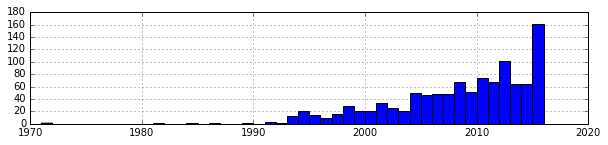

In [729]:
legacybib.year.hist(bins=legacybib.year.max() - legacybib.year.min(), figsize=(10,2))

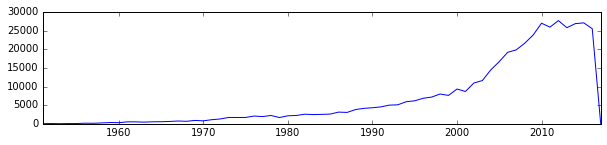

In [730]:
acmPerYear.plot(figsize=(10, 2))

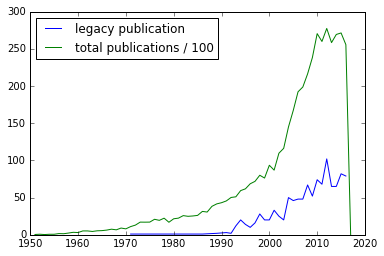

In [740]:
#plt.hist(legacybib.year.dropna(), label="Year histogram")
plt.plot(legacybib.year.groupby(legacybib.year).count(), label='legacy publication')
plt.plot(acmPerYear / 100, label="total publications / 100")
plt.legend()
plt.legend(loc='best')

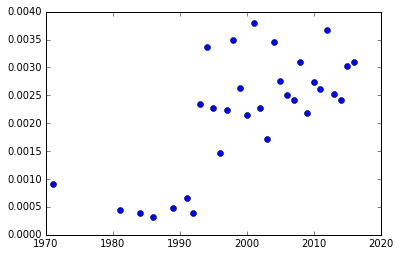

In [741]:
plt.plot(pd.Series(legacybib.groupby(legacybib.year).year.count() / acmPerYear), 'o')

## A histogram of keywords

All keywords are already related to legacy one way or the other, since the data under inspection here is a subset of the total ACM Digital Library.

In [284]:
keywordhist = {}
for kws in legacybib.keywords:
    for k in kws:
        if k in keywordhist:
            keywordhist[k] = keywordhist[k] + 1
        else:
            keywordhist[k] = 1

Total number of unique keywords:

In [285]:
len(keywordhist)

2772

Of which occur in 10 or more items in the subset

In [286]:
[(k, keywordhist[k]) for k in sorted(keywordhist, key=keywordhist.get, reverse=True) if keywordhist[k] >= 10]

[('', 223),
 ('reverse engineering', 24),
 ('security', 23),
 ('java', 22),
 ('legacy software', 18),
 ('refactoring', 18),
 ('legacy systems', 17),
 ('cloud computing', 15),
 ('migration', 15),
 ('virtualization', 14),
 ('reengineering', 13),
 ('software engineering', 13),
 ('design', 12),
 ('interoperability', 11),
 ('software evolution', 10),
 ('multimedia', 10),
 ('soa', 10),
 ('transactional memory', 10),
 ('legacy', 10),
 ('software architecture', 10)]

Time trends of the above keywords

([array([ 0.,  2.,  3.,  0.,  1.,  9.,  3.,  1.,  1.,  2.]),
  array([ 0.,  0.,  0.,  0.,  0.,  6.,  2.,  3.,  3.,  9.]),
  array([ 1.,  2.,  0.,  0.,  3.,  0.,  3.,  5.,  2.,  8.])],
 array([ 1997. ,  1998.9,  2000.8,  2002.7,  2004.6,  2006.5,  2008.4,
         2010.3,  2012.2,  2014.1,  2016. ]),
 <a list of 3 Lists of Patches objects>)

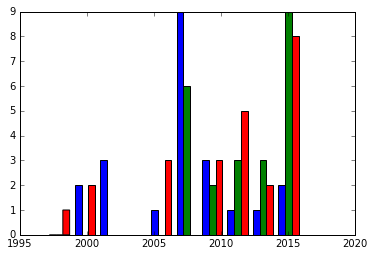

In [338]:
#legacybib[legacybib.keywords.map(lambda i: 'fortran' in i)].year
#plt.plot(legacybib[['java' in kws for kws in legacybib.keywords]].year)
#plt.hist(legacybib[['design' in kws for kws in legacybib.keywords]].year)
plt.hist([legacybib[[pk in kws for kws in legacybib.keywords]].year for pk in keywordhist if keywordhist[pk] > 20 and pk != ''])

and further those that occur in 3-10 items

In [702]:
[(k, keywordhist[k]) for k in sorted(keywordhist, key=keywordhist.get, reverse=True) if keywordhist[k] < 10 and keywordhist[k] >= 3]

[('middleware', 9),
 ('compilers', 9),
 ('performance', 9),
 ('android', 8),
 ('c', 8),
 ('sdn', 8),
 ('memory protection', 8),
 ('parallelism', 8),
 ('code generation', 8),
 ('architecture', 8),
 ('openflow', 8),
 ('measurement', 8),
 ('legacy system', 7),
 ('c++', 7),
 ('concurrency', 7),
 ('scheduling', 7),
 ('usability', 7),
 ('static analysis', 7),
 ('fortran', 7),
 ('integration', 6),
 ('software product lines', 6),
 ('privacy', 6),
 ('gpu', 6),
 ('trusted computing', 6),
 ('multicore', 6),
 ('operating systems', 6),
 ('web services', 6),
 ('jni', 6),
 ('embedded systems', 6),
 ('access control', 5),
 ('foreign function interface', 5),
 ('vmm', 5),
 ('type inference', 5),
 ('eclipse', 5),
 ('mobile devices', 5),
 ('personalization', 5),
 ('death', 5),
 ('user experience', 5),
 ('mobility', 5),
 ('software reengineering', 5),
 ('opencl', 5),
 ('energy efficiency', 5),
 ('corba', 5),
 ('multi-core', 5),
 ('reuse', 5),
 ('open source', 5),
 ('real-time', 5),
 ('patterns', 5),
 ('cas

Of the remainder, number of keywords which appear on only two items

In [703]:
len([k for k in keywordhist if keywordhist[k] == 2])

381

and only on one item

In [704]:
len([k for k in keywordhist if keywordhist[k] == 1])

2138

## Keywords with 'legacy' in them

In [705]:
sorted([(k, keywordhist[k]) for k in keywordhist if re.match("legacy", k)], key=lambda k: k[1], reverse=True)

[('legacy software', 18),
 ('legacy systems', 17),
 ('legacy', 10),
 ('legacy system', 7),
 ('legacy code', 4),
 ('legacy modernization', 3),
 ('legacy programs', 2),
 ('legacy integration', 2),
 ('legacy traffic', 2),
 ('legacy infrastructure', 2),
 ('legacy data', 2),
 ('legacy reuse', 2),
 ('legacy code wrapping', 1),
 ('legacy file formats', 1),
 ('legacy applications', 1),
 ('legacy document conversion', 1),
 ('legacy contact', 1),
 ('legacy support', 1),
 ('legacy software product lines', 1),
 ('legacy bias', 1),
 ('legacy system analysis', 1),
 ('legacy technology', 1),
 ('legacy networks', 1),
 ('legacy migration', 1),
 ('legacy devices', 1),
 ('legacy information systems', 1),
 ('legacy system integration', 1),
 ('legacy assets mining', 1)]

## Network analysis of keywords

Keywords are a comma separated list in `keywords`, let's pull all of them out to a graph.

An analysis of which keywords are actually plentiful, their temporal distibution etc. centrality metrics, subgraph overlap etc. would be great.

In [706]:
keywordg = nx.Graph()
legacybib.keywords.map(lambda item: keywordg.add_edges_from([p for p in itertools.permutations(item, 2)]), na_action='ignore')
print("Number of components", len([comp for comp in nx.connected_components(keywordg)]))
print("Largest ten components sizes", sorted([len(comp) for comp in nx.connected_components(keywordg)], reverse=True)[:10])

Number of components 156
Largest ten components sizes [1625, 13, 11, 11, 11, 10, 9, 9, 9, 9]


Write the graph to a file for exploration with Gephi.

In [795]:
nx.write_gexf(keywordg, "keywordg.gexf")

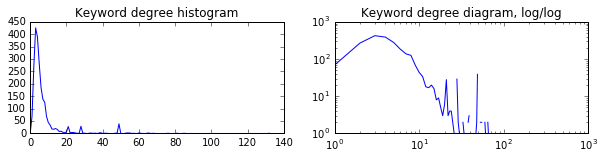

In [707]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(10, 2)
ax1.set_title("Keyword degree histogram")
ax1.plot(nx.degree_histogram(keywordg))
ax2.set_title("Keyword degree diagram, log/log")
ax2.loglog(nx.degree_histogram(keywordg))

In [791]:
from math import sqrt
plt.rcParams["figure.figsize"] = (10, 10)
def plotGraph(graph, keyword, color = "green", removeEgo = True):
    subgraph = graph.subgraph(graph.neighbors(keyword) + [keyword])
    if removeEgo:
        subgraph.remove_node(keyword)
    plt.title("Neighbourhood of " + keyword + " (" + str(len(subgraph)) + ")")
    plt.axis('off')
    pos = nx.spring_layout(subgraph, k = 1/sqrt(len(subgraph) * 2))
    nx.draw_networkx(subgraph,
                     pos = pos,
                     font_size = 9,
                     node_color = color,
                     alpha = 0.8,
                     edge_color = "light" + color)

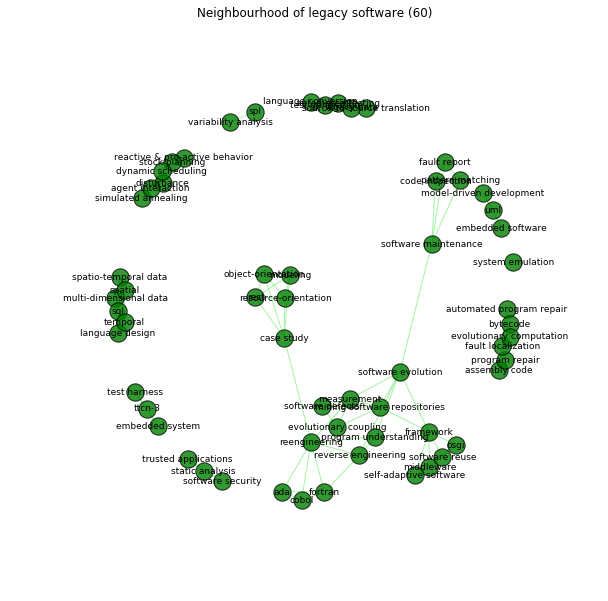

In [792]:
plotGraph(keywordg, "legacy software")

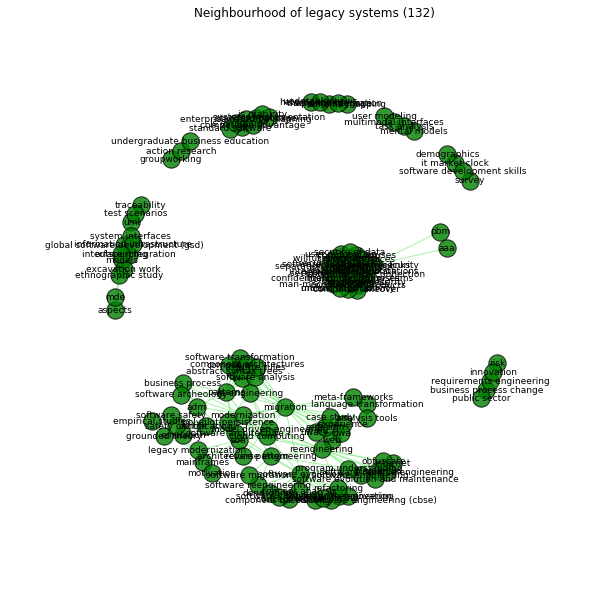

In [793]:
plotGraph(keywordg, "legacy systems")